In [29]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
import glob
import h5py
from scipy.interpolate import griddata
import scipy.integrate as integrate


#import matplotlib as mpl
#mpl.use("pgf")
#pgf_with_custom_preamble = {
#    "font.family": "serif", # use serif/main font for text elements
#    "text.usetex": True,    # use inline math for ticks
#    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
#    "pgf.preamble": [
#         r"\usepackage{units}",         # load additional packages
#         r"\usepackage{metalogo}",
#         r"\usepackage{unicode-math}",  # unicode math setup
#         r"\setmathfont{xits-math.otf}",
#         r"\setmainfont{DejaVu Serif}", # serif font via preamble
#         r"\usepackage{sfmath} \boldmath",
#         ]
#}

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.sans-serif": ["DejaVu Serif"]})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "mathtext.default": "regular",
    "text.latex.preamble": [r"""\usepackage{bm}"""],
})



# for Palatino and other serif fonts use:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#})

#plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
#plt.rcParams['font.size'] = '20'

In [2]:
import athena_read

In [3]:
grav0=1.09465
r0=28.1427
time0=4.54868/24 # in days

rhomin=1.e-6
rhomax=10.0

Trmin=0.01
Trmax=10

rmax=800

In [4]:
files=sorted(glob.glob('star*athdf'))
quantities=['rho','vel1','vel2','vel3','Er']

In [5]:
input_filename=files[0]
with h5py.File(input_filename, 'r') as f:
    attributes = f.attrs.items()
    attrs = dict(attributes)
    level = f.attrs['MaxLevel']
    datatime = f.attrs['Time']
    subsample = False

    data = athena_read.athdf(input_filename, quantities=quantities,
        level=level, subsample=subsample)


In [6]:
x1f=data['x1f']
x2f=data['x2f']
x3f=data['x3f']
x1v=data['x1v']
x2v=data['x2v']
x3v=data['x3v']
rho=data['rho']
vel1=data['vel1']
vel2=data['vel2']
vel3=data['vel3']
Er=data['Er']


In [7]:
nr=int(len(x1v))
ntheta=int(len(x2v))
nphi=int(len(x3v))
# extend radius, theta, phi to 3d grid for all cells
#cell size is d(r^3/3)(dcostheta)dphi
thetapos=np.abs(x2v-0.5*np.pi).argmin()
rmaxpos=np.abs(x1v-rmax).argmin()
grid_phi,grid_r=np.meshgrid(x3v,x1v[:rmaxpos],indexing='ij')

In [8]:
#get radial surface area
rhoslice=rho[:,thetapos,:rmaxpos]
Erslice=Er[:,thetapos,:rmaxpos]

In [9]:
grid_r, grid_phi = np.meshgrid(x1f[:rmaxpos+1], x3f) 
x_grid = grid_r*np.cos(grid_phi)
y_grid = grid_r*np.sin(grid_phi)

In [21]:
output_name1='YSGL_rho_'+input_filename[10:15]+'.png'
timelabel='$t='+f"{datatime*time0:4.1f}"+r'{\ {\rm days}}$'
output_name2='YSGL_Tr_'+input_filename[10:15]+'.png'

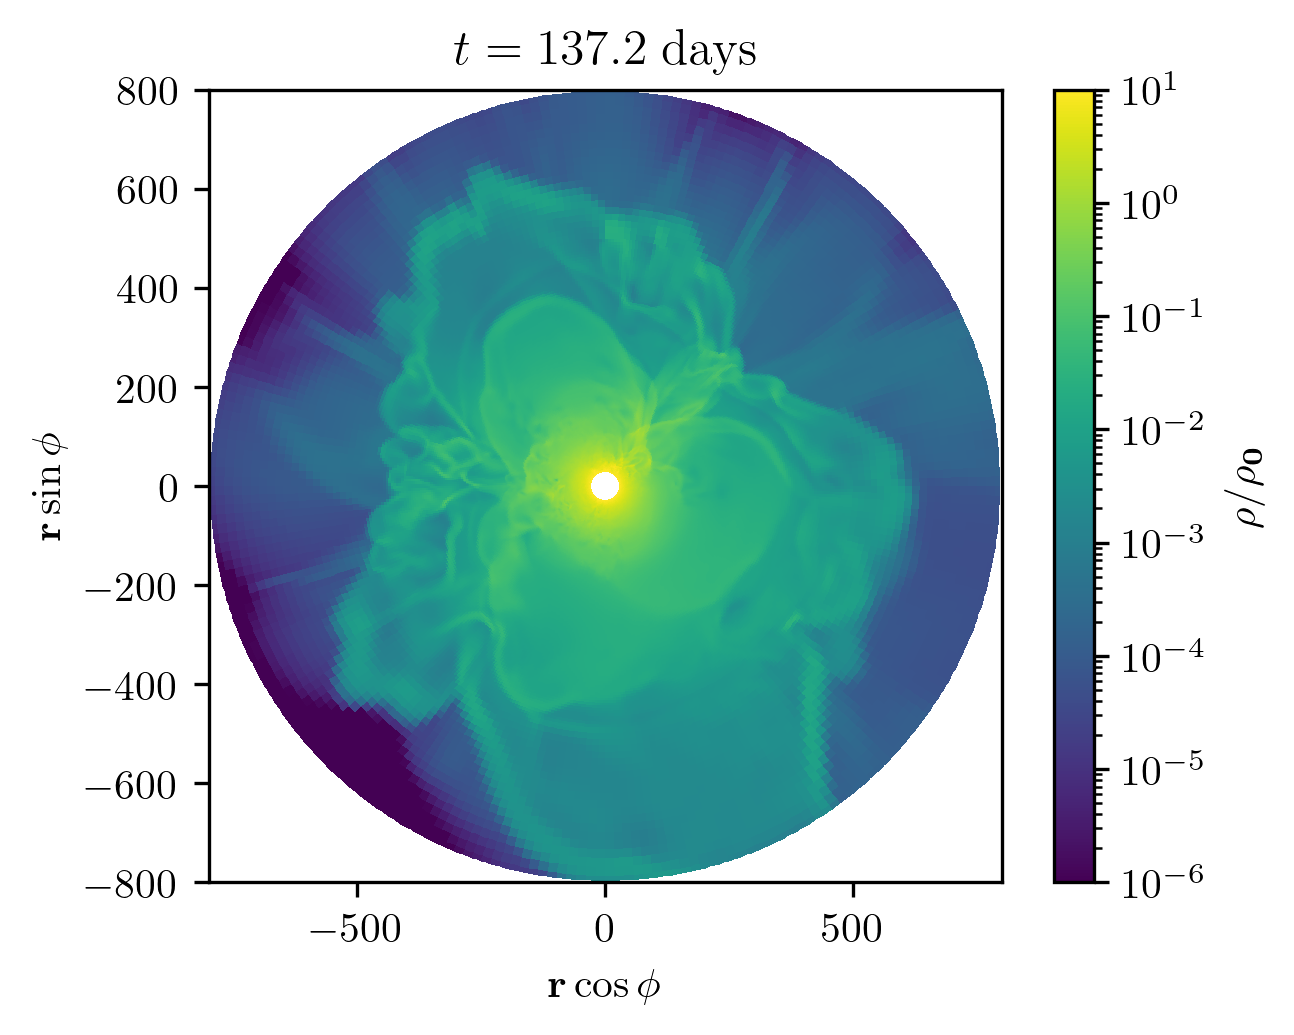

In [34]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(4.5,3.5),dpi=300)
im=axes.pcolormesh(x_grid,y_grid,rhoslice,norm=LogNorm(vmin=rhomin, vmax=rhomax),cmap='viridis')
axes.set_aspect('equal')
axes.set_xlabel(r'$\mathbf{r \cos\phi}$',style='italic')
axes.set_ylabel(r'$\mathbf{r \sin\phi}$',style='italic')
axes.set_ylim([-rmax, rmax])
axes.set_xlim([-rmax,rmax])
cbar=plots.colorbar(im, ax=axes)
cbar.set_label(r'$\mathbf{\rho/\rho_0}$')
plt.title(timelabel,fontweight='bold')
plt.savefig(output_name1)


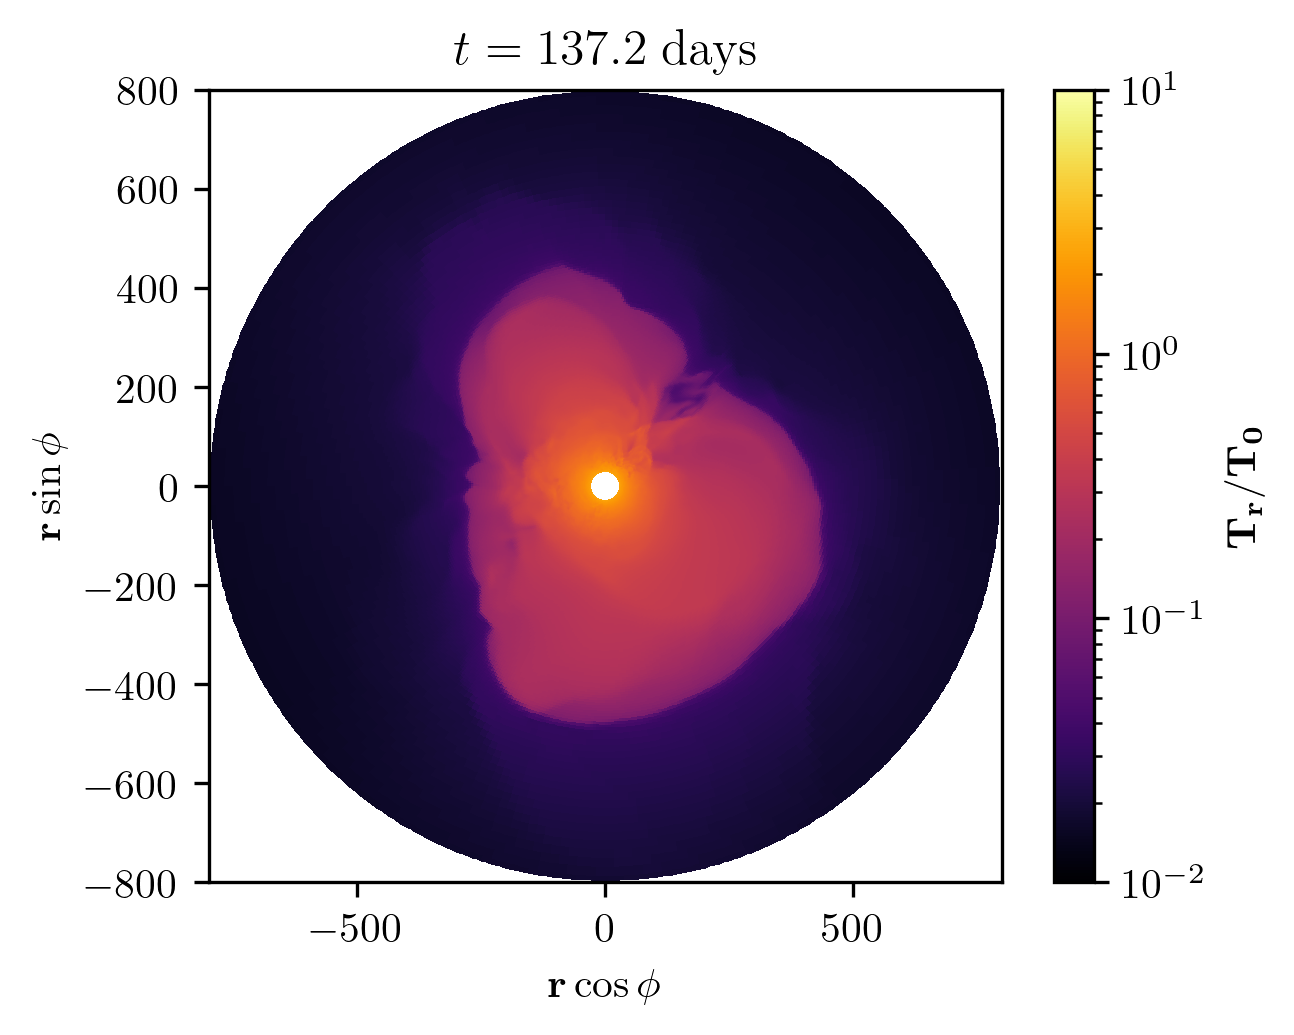

In [33]:
%matplotlib inline
plots, axes = plt.subplots(figsize=(4.5,3.5),dpi=300)
norm=mpl.colors.Normalize(vmin=Trmin, vmax=Trmax)
im=axes.pcolormesh(x_grid,y_grid,Erslice**0.25,norm=LogNorm(vmin=Trmin, vmax=Trmax),cmap='inferno')
axes.set_aspect('equal')
axes.set_xlabel(r'$\mathbf{r \cos\phi}$')
axes.set_ylabel(r'$\mathbf{r \sin\phi}$')
axes.set_ylim([-rmax, rmax])
axes.set_xlim([-rmax,rmax])
cbar=plots.colorbar(im, ax=axes)
cbar.set_label(r'$\mathbf{T_r/T_0}$',style='italic')
plt.title(timelabel)
plt.savefig(output_name2)